In [1]:
import pandas 
import numpy 
import os
import os.path 

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix   
from sklearn.metrics import classification_report

from sklearn.metrics import brier_score_loss 
from sklearn.metrics import auc 

In [2]:
DEFAULT_LINE_COLOUR = numpy.array([228, 26, 28], dtype=float) / 255
DEFAULT_LINE_WIDTH = 3
DEFAULT_RANDOM_LINE_COLOUR = numpy.full(3, 152. / 255)
DEFAULT_RANDOM_LINE_WIDTH = 2

LEVELS_FOR_CONTOURS = numpy.linspace(0, 1, num=11, dtype=float)

FIGURE_WIDTH_INCHES = 10
FIGURE_HEIGHT_INCHES = 10

FONT_SIZE = 20
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('xtick', labelsize=FONT_SIZE)
plt.rc('ytick', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE)
plt.rc('figure', titlesize=FONT_SIZE)

In [3]:
def Optimal_Thr(y, ypred): 
    length = len(ypred) 
    ypred_ = [0]*length
    results = numpy.empty(shape = (1000, 8), dtype='float')
    th_list = numpy.arange(0, 1, 0.001).tolist()
    for j in range(1000):
        th = th_list[j]
        for i in range(length):
            prob = ypred[i, 1] 
            if prob > th:
                ypred_[i] = 1
            else:
                ypred_[i] = 0
        ypred_ = numpy.array(ypred_)
        tn, fp, fn, tp = confusion_matrix(y, ypred_).ravel()
        a = tn     # Hit
        b = fn      # false alarm
        c = fp      # miss
        d = tp    # correct rejection 

        POD = a/(a+c)
        results[j, 0] = POD

        F   = b/(b+d)
        results[j, 1] = F

        FAR  = b/(a+b)
        results[j,2] = FAR

        CSI = a/(a+b+c)
        results[j, 3] = CSI

        PSS = ((a*d)-(b*c))/((b+d)*(a+c))
        results[j, 4] = PSS

        HSS = (2*((a*d)-(b*c)))/(((a+c)*(c+d))+((a+b)*(b+d)))
        results[j, 5] = HSS

        ORSS = ((a*d)-(b*c))/((a*d)+(b*c))
        results[j, 6] = ORSS

        CSS = ((a*d)-(b*c))/((a+b)*(c+d))
        results[j, 7] = CSS
 
    
    return th_list, results
        


In [4]:
def skilled_metrics(y, ypred, metric): 
    threshold_list, result_list = Optimal_Thr(y, ypred)
    if metric == 'PSS':
        PSS = result_list[:, 4]
        raws = numpy.where(PSS == numpy.amax(PSS))[-1] 
        length_raws = len(raws) 
        if length_raws == 1:
            accuray_list = result_list[raws[0], :] 
            optimal_threshold = threshold_list[raws[0]]
        else:
            accuray_list = result_list[raws[-1], :] 
            optimal_threshold = threshold_list[raws[-1]]

    if metric == 'HSS':
        
        HSS = result_list[:, 5]
        raws = numpy.where(HSS == numpy.amax(HSS))[-1] 
        length_raws = len(raws) 
        if length_raws == 1:
            accuray_list = result_list[raws[0], :] 
            optimal_threshold = threshold_list[raws[0]]
        else:
            accuray_list = result_list[raws[-1], :]
            optimal_threshold = threshold_list[raws[-1]]
    print('The optima threshold is: ', optimal_threshold)
    print('POD  : ', accuray_list[0]) 
    print('F    : ', accuray_list[1])
    print('FAR  : ', accuray_list[2])
    print('CSI  : ', accuray_list[3])
    print('PSS  : ', accuray_list[4])
    print('HSS  : ', accuray_list[5])
    print('ORSS : ', accuray_list[6])
    print('CSS  : ', accuray_list[7])

    return accuray_list, result_list 

In [5]:
def ROC_Curve_Plot(FAR, POD, Roc_Auc, O_POD, O_FAR, O_HSS, Th): 
    plt.figure(figsize = (10, 10))

    axes_object = None
    if axes_object is None:
        _, axes_object = plt.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    #textstr = 'Max HSS=%.2f' % (O_HSS) 
    
    textstr = '\n'.join((
    r'Optimal Threshold=%.2f' % (Th, ),
    r'Max HSS=%.2f' % (O_HSS, ), 
    r'FAR=%.2f' % (O_FAR, ), 
    r'POD=%.2f' % (O_POD, )))
    
    
    
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.1)
    


    plt.plot(FAR, POD, linewidth=3, color = 'red')
    #plt.plot([O_FAR, O_FAR], [0, O_POD], 'b--', linewidth=0.5)
    #plt.plot([0, O_FAR], [O_POD, O_POD], 'b--', linewidth=0.5) 
    plt.plot(O_FAR, O_POD, 'bo', markersize=10) 
    plt.plot([0, 1], [0, 1], 'k--')
    
    axes_object.text(O_FAR + 0.02, O_POD - 0.02, textstr, size=50, rotation=0, transform=axes_object.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel('FAR (probability of false detection)',  fontsize=20)
    plt.ylabel('POD (probability of detection)', fontsize=20)
    title_string = 'ROC curve (AUC = {0:.3f})'.format(Roc_Auc)
    plt.title(title_string, fontsize=20)

### 6Hours

In [15]:
dir6 = './6HOURS/C38C0/'
file_name = 'VIS_Prob_TRAIN.csv'

Tr6C0 = pandas.read_csv(dir6 + file_name, header = 0) 
Tr6C0Target = pandas.read_csv('./Tr6C0Target.csv', header = None) 

In [16]:
Tr6C0 = Tr6C0.to_numpy()
Tr6C0Target  = Tr6C0Target.to_numpy().ravel()

In [17]:
accuray_list, result_list = skilled_metrics(Tr6C0Target, Tr6C0, 'HSS') 

<ipython-input-4-389b189f9cd4>:27: RuntimeWarning: invalid value encountered in longlong_scalars
  FAR  = b/(a+b)
<ipython-input-4-389b189f9cd4>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  ORSS = ((a*d)-(b*c))/((a*d)+(b*c))
<ipython-input-4-389b189f9cd4>:42: RuntimeWarning: invalid value encountered in longlong_scalars
  CSS = ((a*d)-(b*c))/((a+b)*(c+d))


The optima threshold is:  0.58
POD  :  0.912621359223301
F    :  0.005040134403584096
FAR  :  0.2231404958677686
CSI  :  0.7230769230769231
PSS  :  0.9075812248197169
HSS  :  0.8359421557547946
ORSS :  0.9990304490856098
CSS  :  0.775173795197974


In [180]:
accuray_list, result_list = skilled_metrics(Tr6C0Target, Tr6C0, 'HSS') 

The optima threshold is:  0.5800000000000004
POD  :  0.912621359223301
F    :  0.005040134403584096
FAR  :  0.2231404958677686
CSI  :  0.7230769230769231
PSS  :  0.9075812248197169
HSS  :  0.8359421557547946
ORSS :  0.9990304490856098
CSS  :  0.775173795197974


(1000,)
(1000,)


<Figure size 720x720 with 0 Axes>

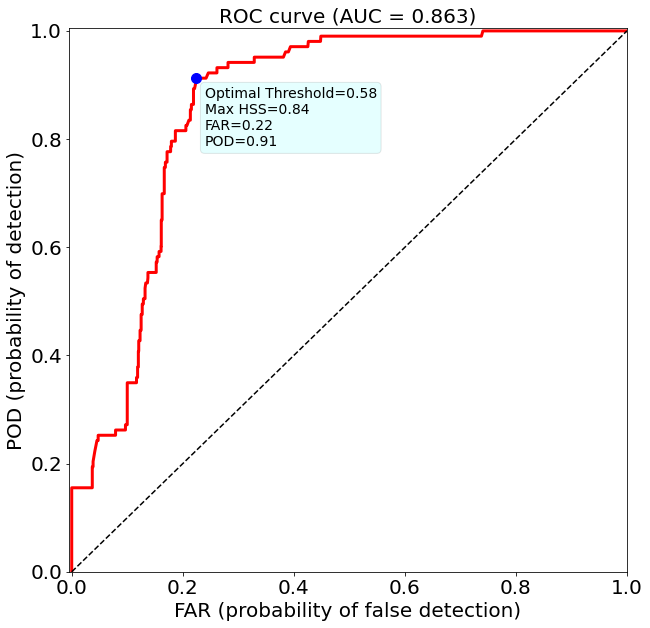

In [18]:
O_POD = accuray_list[0]
O_HSS = accuray_list[5]
O_FAR = accuray_list[2] 
POD = result_list[:, 0] 
print(POD.shape)
FAR = result_list[:, 2]
print(FAR.shape)
FAR = numpy.nan_to_num(FAR, nan = 1)
FAR = numpy.sort(FAR)
#print(FAR.shape) 

Roc_Auc = auc(FAR, POD)

_ = ROC_Curve_Plot(FAR, POD, Roc_Auc, O_POD, O_FAR, O_HSS, 0.58) 

### 12 Hours

In [6]:
dir12 = './12HOURS/C1C0/'
file_name = 'VIS_Prob_TRAIN.csv'

Tr12C0 = pandas.read_csv(dir12 + file_name, header = 0) 
Tr12C0 = Tr12C0.to_numpy()

In [7]:
Tr12C0Target = pandas.read_csv('./Tr12C0Target.csv', header = 0) 
Tr12C0T = Tr12C0Target['VIS_Cat']
Tr12C0T = Tr12C0T.replace(2, 1)
Tr12C0T = Tr12C0T.replace(3, 1)
Tr12C0T = Tr12C0T.replace(4, 1)

Tr12C0T = Tr12C0T.to_numpy().ravel()

In [9]:
accuray_list12, result_list12 = skilled_metrics(Tr12C0T, Tr12C0, 'HSS') 

<ipython-input-3-389b189f9cd4>:27: RuntimeWarning: invalid value encountered in longlong_scalars
  FAR  = b/(a+b)
<ipython-input-3-389b189f9cd4>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  ORSS = ((a*d)-(b*c))/((a*d)+(b*c))
<ipython-input-3-389b189f9cd4>:42: RuntimeWarning: invalid value encountered in longlong_scalars
  CSS = ((a*d)-(b*c))/((a+b)*(c+d))


The optima threshold is:  0.538
POD  :  0.8349514563106796
F    :  0.0026134030240806422
FAR  :  0.14
CSI  :  0.7350427350427351
PSS  :  0.8323380532865989
HSS  :  0.8443986835573369
ORSS :  0.9989646231750395
CSS  :  0.8568283582089552


In [196]:
accuray_list12, result_list12 = skilled_metrics(Tr12C0T, Tr12C0, 'HSS') 

C:\Users\hkamangir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\hkamangir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\hkamangir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in longlong_scalars


The optima threshold is:  0.538
POD  :  0.8349514563106796
F    :  0.0026134030240806422
FAR  :  0.14
CSI  :  0.7350427350427351
PSS  :  0.8323380532865989
HSS  :  0.8443986835573369
ORSS :  0.9989646231750395
CSS  :  0.8568283582089552


(1000,)
(1000,)


<Figure size 720x720 with 0 Axes>

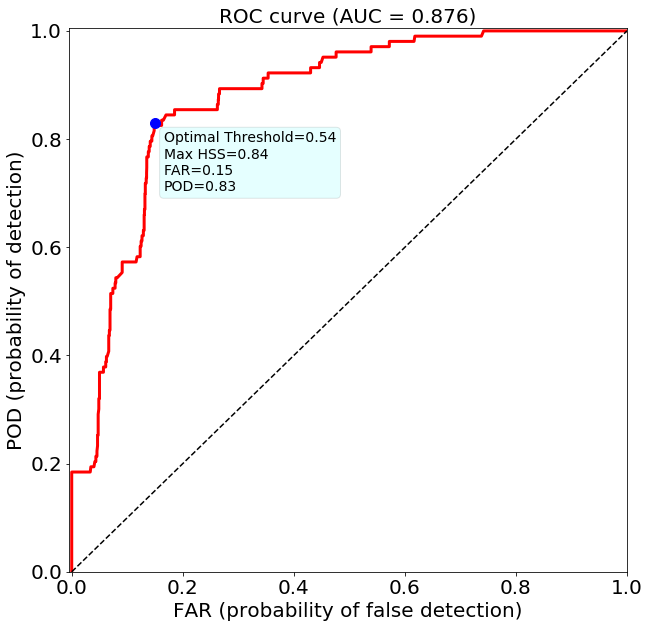

In [206]:
O_POD = accuray_list12[0]
O_HSS = accuray_list12[5]
O_FAR = accuray_list12[2] 
POD = result_list12[:, 0] 
print(POD.shape)
FAR = result_list12[:, 2]
print(FAR.shape)
FAR = numpy.nan_to_num(FAR, nan = 1)
FAR = numpy.sort(FAR)
#print(FAR.shape) 

Roc_Auc = auc(FAR, POD)

_ = ROC_Curve_Plot(FAR, POD, Roc_Auc, 0.83, 0.15, O_HSS, 0.538) 

### 24 Hours

In [10]:
dir24 = './24HOURS/C41C0/'
file_name = 'VIS_Prob_TRAIN.csv'

Tr24C0 = pandas.read_csv(dir24 + file_name, header = 0) 
Tr24C0 = Tr24C0.to_numpy()

In [11]:
Tr24C0Target = pandas.read_csv('./Tr24C0Target.csv', header = 0) 
Tr24C0T = Tr24C0Target['CAT']
#Tr24C0T = Tr24C0T.replace(2, 1)
#Tr24C0T = Tr24C0T.replace(3, 1)
#Tr24C0T = Tr24C0T.replace(4, 1)
Tr24C0T = Tr24C0T.to_numpy().ravel()

In [210]:
accuray_list24, result_list24 = skilled_metrics(Tr24C0T, Tr24C0, 'HSS') 

C:\Users\hkamangir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\hkamangir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\hkamangir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in longlong_scalars


The optima threshold is:  0.482
POD  :  0.8543689320388349
F    :  0.003546761246966586
FAR  :  0.17757009345794392
CSI  :  0.7213114754098361
PSS  :  0.8508221707918684
HSS  :  0.8349218092797348
ORSS :  0.9987873088681762
CSS  :  0.8196277395329024


In [12]:
accuray_list24, result_list24 = skilled_metrics(Tr24C0T, Tr24C0, 'HSS') 

<ipython-input-3-389b189f9cd4>:27: RuntimeWarning: invalid value encountered in longlong_scalars
  FAR  = b/(a+b)
<ipython-input-3-389b189f9cd4>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  ORSS = ((a*d)-(b*c))/((a*d)+(b*c))
<ipython-input-3-389b189f9cd4>:42: RuntimeWarning: invalid value encountered in longlong_scalars
  CSS = ((a*d)-(b*c))/((a+b)*(c+d))


The optima threshold is:  0.482
POD  :  0.8543689320388349
F    :  0.003546761246966586
FAR  :  0.17757009345794392
CSI  :  0.7213114754098361
PSS  :  0.8508221707918684
HSS  :  0.8349218092797348
ORSS :  0.9987873088681762
CSS  :  0.8196277395329024


(1000,)
(1000,)


<Figure size 720x720 with 0 Axes>

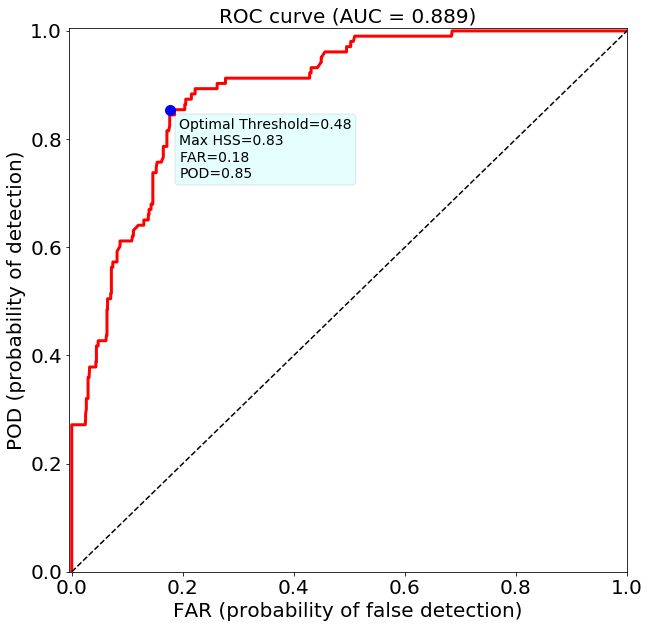

In [211]:
O_POD = accuray_list24[0]
O_HSS = accuray_list24[5]
O_FAR = accuray_list24[2] 
POD = result_list24[:, 0] 
print(POD.shape)
FAR = result_list24[:, 2]
print(FAR.shape)
FAR = numpy.nan_to_num(FAR, nan = 1)
FAR = numpy.sort(FAR)
#print(FAR.shape) 

Roc_Auc = auc(FAR, POD)

_ = ROC_Curve_Plot(FAR, POD, Roc_Auc, O_POD, O_FAR, O_HSS, 0.482) 

## FogNet

In [15]:
Tr24C0 = pandas.read_csv('./VIS_Prob_TRAIN.csv', header = 0) 
Tr24C0 = Tr24C0.to_numpy() 

Tr24C0Target = pandas.read_csv('./Tr24C0Target.csv', header = 0) 
Tr24C0T = Tr24C0Target['CAT']
Tr24C0T = Tr24C0T.to_numpy().ravel()

In [16]:
accuray_list24, result_list24 = skilled_metrics(Tr24C0T, Tr24C0, 'HSS') 

<ipython-input-3-389b189f9cd4>:27: RuntimeWarning: invalid value encountered in longlong_scalars
  FAR  = b/(a+b)
<ipython-input-3-389b189f9cd4>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  ORSS = ((a*d)-(b*c))/((a*d)+(b*c))
<ipython-input-3-389b189f9cd4>:42: RuntimeWarning: invalid value encountered in longlong_scalars
  CSS = ((a*d)-(b*c))/((a+b)*(c+d))


The optima threshold is:  0.193
POD  :  0.941747572815534
F    :  0.0018667164457718873
FAR  :  0.09345794392523364
CSI  :  0.8584070796460177
PSS  :  0.939880856369762
HSS  :  0.9223161455434046
ORSS :  0.999768660874192
CSS  :  0.9054211892711048


(1000,)
(1000,)


<Figure size 720x720 with 0 Axes>

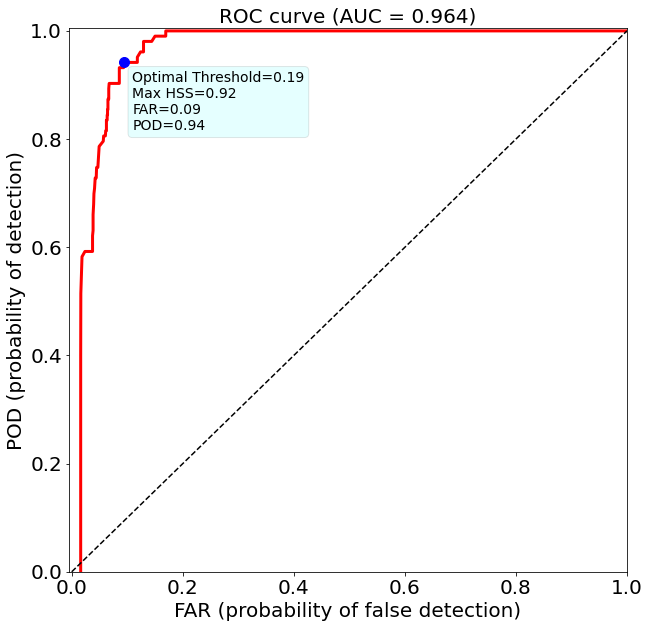

In [17]:
O_POD = accuray_list24[0]
O_HSS = accuray_list24[5]
O_FAR = accuray_list24[2] 
POD = result_list24[:, 0] 
print(POD.shape)
FAR = result_list24[:, 2]
print(FAR.shape)
FAR = numpy.nan_to_num(FAR, nan = 1)
FAR = numpy.sort(FAR)
#print(FAR.shape) 

Roc_Auc = auc(FAR, POD)

_ = ROC_Curve_Plot(FAR, POD, Roc_Auc, O_POD, O_FAR, O_HSS, 0.193) 

In [19]:
Test24C0 = pandas.read_csv('./VIS_Prob_TEST.csv', header = 0) 
Test24C0 = Test24C0.to_numpy() 

Test24C0Target = pandas.read_csv('./VIS_True_TEST.csv', header = 0) 
Test24C0T = Test24C0Target['CAT']
Test24C0T = Test24C0T.to_numpy().ravel()